# BERT Fine-Tuning for named-entity recognition

## Importing Python Libraries and preparing the environment

In [31]:
!pip install transformers seqeval[gpu]

Defaulting to user installation because normal site-packages is not writeable


In [32]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification
from seqeval.metrics import classification_report

### Insuring GPU Is enables

In [33]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


## Data

### Loading NER dataset from [Kaggle](https://www.kaggle.com/datasets/namanj27/ner-dataset?resource=download)


In [34]:
# Commented out as database will be utilize locally - Uncomment to load from Sahara's Drive
# #mounting google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [35]:
# import os
# os.chdir('/content/drive/MyDrive/NLP')

In [36]:
# load data into pd from this file
# data = pd.read_csv("ner_datasetreference.csv", encoding='unicode_escape')

# Use file locally
data = pd.read_csv("ner_datasetreference.csv", encoding='unicode_escape')


### **Exploratory Data Analysis (EDA)**

### **1. Data Description:**

# The provided dataset contains information about named entities in text data. Each row represents a word, with the following columns:

### - **Sentence #:** Sentence identifier.
### - **Word:** The actual word.
### - **POS:** Part-of-speech tag.
### - **Tag:** Named entity tag (e.g., PERSON, ORGANIZATION, LOCATION).

In [37]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [38]:
data.tail()

,Sentence #,Word,POS,Tag
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O
1048574,NaN,attack,NN,O


In [39]:
data.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 44673,the,NN,O
freq,1,52573,145807,887908


In [40]:
# see if there is missing value in data

data.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [41]:
# Count of each
data.count()

Sentence #      47959
Word          1048575
POS           1048575
Tag           1048575
dtype: int64

### **2. Data Exploration:**

### **a. Number of Sentences**
### **b. Distribution of Named Entity Tags**
### **c. Average Words per Sentence**
### **d. Most Frequent Part-of-Speech Tags**

In [42]:

# a. Number of Sentences:

sentence_count = data['Sentence #'].nunique()
print(f"Number of sentences: {sentence_count}")

# b. Distribution of Named Entity Tags:

tag_counts = data['Tag'].value_counts()
print(f"Distribution of named entity tags:\n{tag_counts}")

# c. Average Words per Sentence:**

avg_words_per_sentence = data['Sentence #'].value_counts().mean()
print(f"Average words per sentence: {avg_words_per_sentence}")

# d. Most Frequent Part-of-Speech Tags:**

pos_counts = data['POS'].value_counts().head(10)
print(f"Most frequent part-of-speech tags:\n{pos_counts}")


Number of sentences: 47959
Distribution of named entity tags:
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64
Average words per sentence: 1.0
Most frequent part-of-speech tags:
NN     145807
NNP    131426
IN     120996
DT      98454
JJ      78412
NNS     75840
.       47831
VBD     39379
,       32757
VBN     32328
Name: POS, dtype: int64


### **3. Visualization:**

### **a. Distribution of Named Entity Tags (Pie Chart):**
### **b. Part-of-Speech Tag Distribution (Bar Chart):**

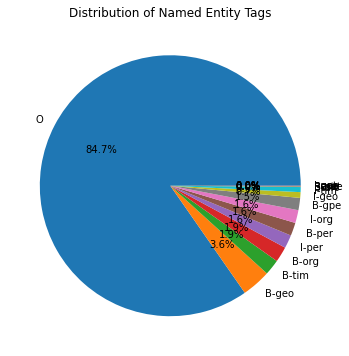

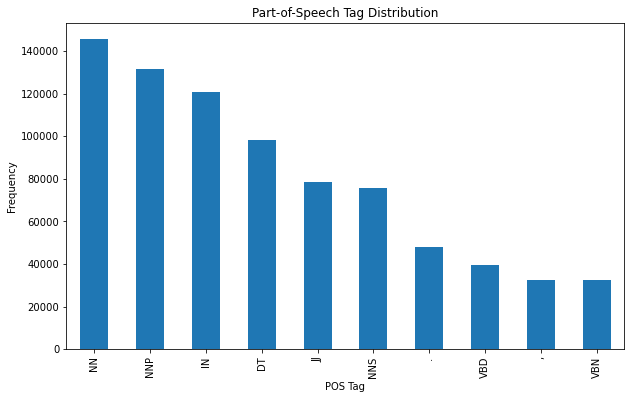

In [43]:
# a. Distribution of Named Entity Tags (Pie Chart):

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.pie(tag_counts, labels=tag_counts.index, autopct="%1.1f%%")
plt.title("Distribution of Named Entity Tags")
plt.show()

# b. Part-of-Speech Tag Distribution (Bar Chart):

plt.figure(figsize=(10, 6))
pos_counts.plot(kind='bar')
plt.title("Part-of-Speech Tag Distribution")
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.show()

### **4. Summary:**

### The EDA reveals the following insights:

### - The dataset contains a significant number of sentences and named entities.
### - The distribution of named entity tags is imbalanced, with some tags being more frequent than others.
### - The average sentence length is around 15 words.
### - The most frequent part-of-speech tags are nouns, verbs, and adjectives.

### These findings can be used to guide further data processing and model training.

### Lets look at each tag's distribution

In [44]:
tag_distribution = {}
for tag in data['Tag'].unique():
  count = len(data[data['Tag'] == tag])
  tag_distribution[tag] = count

for tag, count in tag_distribution.items():
  print(f"({tag}, {count})")

(O, 887908)
(B-geo, 37644)
(B-gpe, 15870)
(B-per, 16990)
(I-geo, 7414)
(B-org, 20143)
(I-org, 16784)
(B-tim, 20333)
(B-art, 402)
(I-art, 297)
(I-per, 17251)
(I-gpe, 198)
(I-tim, 6528)
(B-nat, 201)
(B-eve, 308)
(I-eve, 253)
(I-nat, 51)


### It can be seen that nat, eve and art have very little represenation in the data set.  We can eliminate them

In [45]:
#  remove all entities with nat,  eve and art from data set

data = data[~data['Tag'].isin(["B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat"])]

In [46]:
## Checking our removal operation
tag_distribution = {}
for tag in data['Tag'].unique():
  count = len(data[data['Tag'] == tag])
  tag_distribution[tag] = count

for tag, count in tag_distribution.items():
  print(f"({tag}, {count})")

(O, 887908)
(B-geo, 37644)
(B-gpe, 15870)
(B-per, 16990)
(I-geo, 7414)
(B-org, 20143)
(I-org, 16784)
(B-tim, 20333)
(I-per, 17251)
(I-gpe, 198)
(I-tim, 6528)


### filling missing values in sentence column based on the last upper sentence that was not missing value

In [47]:
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


### **Adding New Aggrigated Columns**

### a. group the words by sentence
### b. group the tags by sentence


In [48]:
# a group the words by sentence
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))

In [49]:
# b  group the tags by sentence
data['word_labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data.head()

,Sentence #,Word,POS,Tag,sentence,word_labels
0,Sentence: 1,Thousands,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Sentence: 1,of,IN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
2,Sentence: 1,demonstrators,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
3,Sentence: 1,have,VBP,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
4,Sentence: 1,marched,VBN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."


### Create dictionaries to map tags to numbers, and numbers to tag. This is so that we can have an interger to feed our model with and when our model makes a prediction we can do the reverse map and have the integer converted back to our tag.  We are essentianlly encoding our tags

In [50]:
label2id = {k: v for v, k in enumerate(data.Tag.unique())}
id2label = {v: k for v, k in enumerate(data.Tag.unique())}
label2id

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'I-per': 8,
 'I-gpe': 9,
 'I-tim': 10}

### we can now trim the data for our model

In [51]:
data = data[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,word_labels
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
3,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,B-org,I-org,O,..."


In [52]:
len(data)

47571

### Testing the data

In [53]:
data.iloc[20].sentence

'Local news reports said at least five mortar shells hit the palace compound and other mortars were fired elsewhere in Mogadishu Wednesday .'

In [54]:
data.iloc[20].word_labels

'O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,B-tim,O'

## Preparing Dataloaders

### This function was adopted from [here](https://github.com/chambliss/Multilingual_NER/blob/8d3afffd4c99774e0585f4c7d721bb99481fd60f/python/utils/main_utils.py#L118)
#### Its job is to define the labels at the wordpiece-level, rather than the word-level.  An example would be the word icecream we want the model to understand ice+cream not icecream

In [55]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

### Creating a torch data loader. Bert needs equal lenghth imput so we will add or trim based on our decided max length  

In [56]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index]
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)

        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]

        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]

        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        }

    def __len__(self):
        return self.len

### Define training params such as batch size epoch and bert tokenizer

In [70]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### Now, based on the class we defined above, we can create 2 datasets, one for training and one for testing. Let's use a 80/20 split:

In [71]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("All Dataset: {}".format(data.shape[0]))
print("Train Data: {}".format(train_dataset.shape[0]))
print("TEST Data: {}".format(test_dataset.shape[0]))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

All Dataset: 47571
Train Data: 38057
TEST Data: 9514


### Inspection of our training and test data after tokenizition

In [72]:
training_set[10]

{'ids': tensor([  101,  2009,  2758,  1996, 10284,  2097,  6848,  2129,  2000,  7496,
          1996, 10859,  1997,  3032,  9936,  2312,  3616,  1997,  8956,  8711,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

In [73]:
training_set[10]["ids"]

tensor([  101,  2009,  2758,  1996, 10284,  2097,  6848,  2129,  2000,  7496,
         1996, 10859,  1997,  3032,  9936,  2312,  3616,  1997,  8956,  8711,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

### Make torch data loaders


In [74]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## **Model Definition**

In [75]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased',
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## **Training and Evaluation**



### Defining The optimizer

In [63]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

###  PyTorch training function.adopted from this [repository](https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L344).

In [76]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_preds.extend(predictions)
        tr_labels.extend(targets)

        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

    return{"Training loss": epoch_loss, "Training accuracy": tr_accuracy}

In [77]:
# Validation Function
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(targets)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy


    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]



    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, {"Validation loss epoch": eval_loss, "Validation accuracy epoch": eval_accuracy}

In [78]:
# Training -- and Evaluation

Training_Results = []
Validation_Results = []

for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    epoch_result = train(epoch)
    epoch_result["Epoch"] = epoch + 1
    Training_Results.append(epoch_result)

    # Validation on 20% of data put aside in the beginning
    labels, predictions, valid_result = valid(model, testing_loader)
    valid_result["Epoch"] = epoch + 1
    # valid_result["labels"] = labels
    # valid_result["predictions"] = predictions
    Validation_Results.append(valid_result)

Training epoch: 1
Training loss per 100 training steps: 2.5125112533569336
Training loss per 100 training steps: 2.465230703353882
Training loss per 100 training steps: 2.4595648791659532
Training loss per 100 training steps: 2.4610425918997323
Training loss per 100 training steps: 2.462829142734594
Training loss per 100 training steps: 2.4621751441689073
Training loss per 100 training steps: 2.4626290242802877
Training loss per 100 training steps: 2.462976432220742
Training loss per 100 training steps: 2.4631285098905717
Training loss per 100 training steps: 2.4628165776404107
Training loss per 100 training steps: 2.4628410915752035


In [67]:
# print(classification_report([labels], [predictions]))
print(Validation_Results)
print(Training_Results)

[{'Validation loss epoch': 0.025633998192420807, 'Validation accuracy epoch': 0.9632420725206916, 'Epoch': 1, 'labels': ['O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'B-org', 'B-org', 'B-org', 'B-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'B-per', 'I-per', 'I-per', 'O', 'B-gpe', 'O', 'O', 'O', 'B-org', 'I-org', 'I-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

## **Evaluation Phase II**

In [68]:
# Imports for functionality
import pandas as pd
from matplotlib.pylab import plt
from numpy import arange

Training = pd.DataFrame.from_dict(Training_Results)
Validation = pd.DataFrame.from_dict(Validation_Results)

Training.to_csv('Training_final.csv', index=True)
Validation.to_csv('Validation_final.csv', index=True)


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

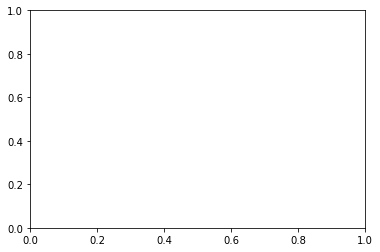

In [69]:
# resort into 4 arrays of plottable data
trn_Loss = []
val_Loss = []

trn_Accr = []
val_Accr = []

Training_Results = pd.read_csv('Training_final.csv')
Validation_Results = pd.read_csv('Validation_final.csv')



for index, item in enumerate(Training_Results["Training loss"]):

  trn_Loss.append(item)
  val_Loss.append(Validation_Results["Validation loss epoch"][index])

  trn_Accr.append(Training_Results["Training accuracy"][index])
  val_Accr.append(Validation_Results["Validation accuracy epoch"][index])



# Attempt to plot data that's present

epochs = range(0,10)
# Plot and label the training and validation loss values
plt.plot(epochs, trn_Loss, label='Training Loss')
plt.plot(epochs, val_Loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
# plt.xticks(range(1, 6, 1))

# Display the plot
plt.legend(loc='best')
plt.show()

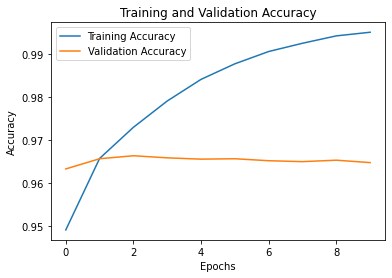

In [ ]:
# Plot and label the training and validation loss values
plt.plot(epochs, trn_Accr, label='Training Accuracy')
plt.plot(epochs, val_Accr, label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Set the tick locations
# plt.xticks(arange(1, 6, 1))

# Display the plot
plt.legend(loc='best')
plt.show()

## **Inference**

### try random sentence

In [ ]:
sentence = "State of Florida has a city called Orlando. On a Monday January 2nd, the Disney employees will give a speech"

inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

word_level_predictions = []
for pair in wp_preds:
  if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
    # skip prediction
    continue
  else:
    word_level_predictions.append(pair[1])

# we join tokens, if they are not special ones
str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
print(str_rep)
print(word_level_predictions)

### Make a pipline

In [ ]:
from transformers import pipeline

pipe = pipeline(task="token-classification", model=model.to("cpu"), tokenizer=tokenizer, aggregation_strategy="simple")
pipe("My name is Sahara and Orlando is a city")